In [1]:
## Imports

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
#Defining Data types for each column for efficiency

dtypes = {
    "date": pl.Utf8,
    "cell_ll_lat": pl.Float32,
    "cell_ll_lon": pl.Float32,
    "mmsi": pl.Int32,
    "hours": pl.Float32,
    "fishing_hours": pl.Float32,
    "flag_registry": pl.Categorical,
    "flag_gfw": pl.Categorical,
    "vessel_class_inferred": pl.Categorical
}

#Using a lazy approach for efficiency

df_lazy = pl.scan_csv('MMSI-daily_merged_2019_2020-vessels-gfw-seasons.csv', schema_overrides=dtypes)

#This replaces missing flag_registry entries with flag_gfw
df_lazy = df_lazy.with_columns(
    pl.coalesce([pl.col("flag_registry"), pl.col("flag_gfw")]).alias("flag_registry")
)

In [3]:
# This block's point is to sample the rows to reduce memory usage for later models (100% of the data could take days to process)
df_lazy = df_lazy.with_row_index("index")
row_count_df = df_lazy.select(pl.count("index").alias("row_count")).collect()
row_count = row_count_df["row_count"][0]
sample_n = int(0.05 * row_count)
sample_indices = sorted(np.random.choice(row_count, size=sample_n, replace=False))
df_lazy = df_lazy.filter(pl.col("index").is_in(sample_indices)).drop("index")

In [4]:
# Collecting the lazy frames here
df_polars = df_lazy.collect()
#I converted the polars set to pandas from here
df = df_polars.to_pandas()

In [5]:
# Creating dummy variables for flag_registry so I get binary indicators for country flags
flag_dummies = pd.get_dummies(df['flag_registry'], prefix='flag')
df = pd.concat([df, flag_dummies], axis=1)

# Dummy variables for vessel class
df = pd.get_dummies(df, columns=['vessel_class_registry'], drop_first=True)
# Saving the names for aggregation later
vessel_class_cols = [col for col in df.columns if col.startswith('vessel_class_registry_')]

#Here we are grouping coordinates and season, for each group we sum hours, fishing_hours, flag dummy values and vessel_class dummy values
#This allows us to predict vessel counts by flag for each cell in a season
agg_df = df.groupby(['cell_ll_lat', 'cell_ll_lon', 'season']).agg({
    'hours': 'sum',
    'fishing_hours': 'sum',
    **{col: 'sum' for col in flag_dummies.columns},
    **{col: 'sum' for col in vessel_class_cols}
}).reset_index()

# Dummies for season, since we did this as a grouping key we generate the dummies after. While we generated the dummies for flag and vessels for summing aggregate counts.
agg_df = pd.get_dummies(agg_df, columns=['season'], drop_first=True)

#put my features and targets into variable for readability
features = ['cell_ll_lat', 'cell_ll_lon', 'hours', 'fishing_hours'] + \
           [col for col in df.columns if col.startswith('season_') or 
                                    col.startswith('vessel_class_registry_')]

targets = [col for col in agg_df.columns if col.startswith('flag_')]

#Define X and y
X = agg_df[features]
y = agg_df[targets]

#Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
# Deleting unnecessary dataframes to free up memory
del df, df_lazy, df_polars

In [6]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_preds, squared=False)
print(f'Linear Regression RMSE: {lr_rmse}')

Linear Regression RMSE: 0.3568829239327641


In [7]:
# Random Forest Model
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=5, random_state=20, n_jobs=-1))
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False, multioutput='raw_values')
print(f'Random Forest RMSE per flag: {rf_rmse}')

Random Forest RMSE per flag: [6.48245698e-01 4.58848137e-01 7.09155592e+00 9.71942634e-01
 6.18486731e-01 1.12590407e-01 7.50282334e-02 6.98186741e-02
 7.13829636e-02 5.18317640e-01 4.18846130e-01 1.32804447e+00
 1.45045072e-01 8.32843432e-02 6.77301595e-02 8.64016125e-02
 1.26823465e-01 7.10882168e-02 3.77159710e-02 4.83370454e-01
 3.74837234e-02 2.34852831e-02 6.05631594e-02 2.17772917e-02
 3.14851865e-01 5.01416219e-02 7.61191532e-02 6.09731314e-02
 5.29893944e-02 9.95196840e-02 2.85697316e-02 1.35841833e-01
 3.54721923e-01 3.05696455e-02 4.68226960e-02 7.05578458e-02
 1.49740331e-01 6.33053226e-02 4.95257315e-02 3.82907630e-01
 2.99200116e-02 4.77138089e-02 2.12822208e-02 8.21408608e-02
 8.41586549e-02 3.70911047e-02 4.93066987e-01 3.37494327e-01
 8.91722427e-02 1.51086740e-01 3.09496458e-01 4.23863502e-01
 1.21447665e-01 9.34325941e-02 3.63043423e-01 6.96005171e-01
 2.04600659e-01 5.22207259e-01 3.12933835e-01 1.00803721e-01
 3.84427230e-02 5.90459908e-01 6.24351751e-02 2.57373189

In [8]:
#Gradient Boost Model
gb_model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=5, random_state=20))
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
gb_rmse = mean_squared_error(y_test, gb_preds, squared=False, multioutput='raw_values')
print(f'Gradient Boosting RMSE per flag: {gb_rmse}')

Gradient Boosting RMSE per flag: [2.23724736e+00 1.35889845e+00 1.29927923e+01 1.81958811e+00
 1.24844517e+00 1.26589948e-01 8.33002453e-02 7.41283675e-02
 1.57987452e-01 1.35475196e+00 1.80588566e+00 2.91246688e+00
 1.55080192e-01 1.14428447e-01 9.57983259e-02 1.12347576e-01
 2.15213669e-01 7.58712309e-02 3.64631000e-02 1.48870426e+00
 4.11910113e-02 2.56475203e-02 6.99173421e-02 2.65883086e-02
 4.25607956e-01 5.90519970e-02 1.05515159e-01 6.34998158e-02
 5.07773376e-02 4.62887057e-01 2.93054952e-02 2.24845130e-01
 1.50944669e+00 2.76739620e-02 7.17808937e-02 8.77170789e-02
 2.82173618e-01 1.39887614e-01 9.73662278e-02 8.86495318e-01
 6.49188762e-02 1.11834597e-01 9.88206439e-02 1.76742220e-01
 3.12443242e-01 8.14054351e-02 1.20690947e+00 6.87395554e-01
 2.84253745e-01 4.89452702e-01 6.05650710e-01 1.26008057e+00
 9.70249282e-02 2.98875719e-01 8.05665441e-01 1.38305650e+00
 4.00055552e-01 1.30484639e+00 5.53049803e-01 1.43778217e-01
 3.77785244e-02 1.54677325e+00 1.49882687e-01 5.5395

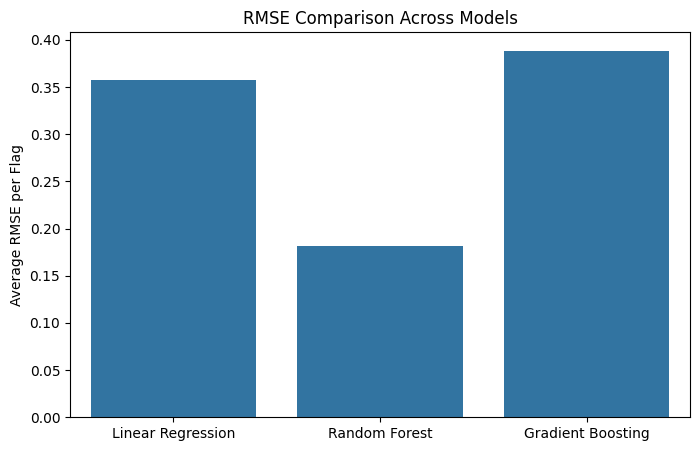

In [11]:
rmse_scores = {"Linear Regression":lr_rmse,"Random Forest": rf_rmse.mean(), "Gradient Boosting": gb_rmse.mean()}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(rmse_scores.keys()), y=list(rmse_scores.values()))
plt.ylabel("Average RMSE per Flag")
plt.title("RMSE Comparison Across Models")
plt.show()

#Interestingly the Gradient Boost model is not better than our baseline of simple linear regression. Out of these three Random Forest seems to perform the best.

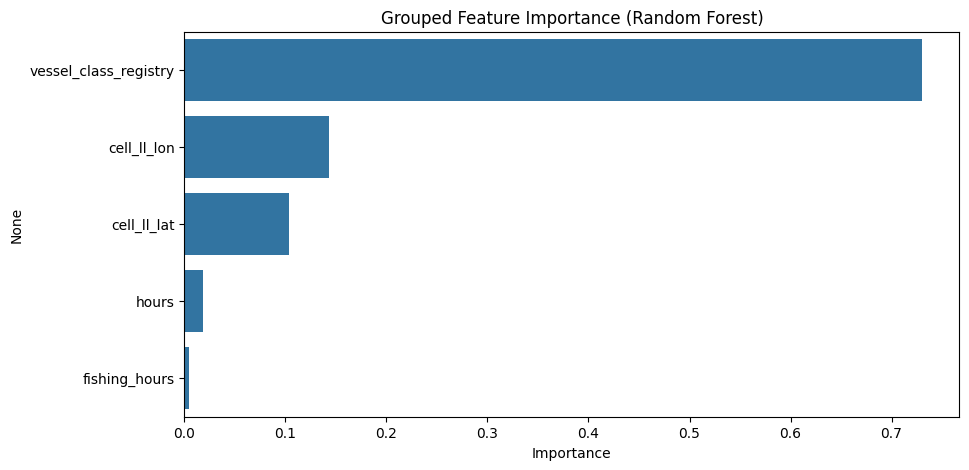

In [16]:
fi = pd.Series(rf_model.estimators_[0].feature_importances_, index=features)
vessel_class_mask = fi.index.str.startswith('vessel_class_registry_')
vessel_class_importance = fi[vessel_class_mask].sum()
fi_grouped = fi[~vessel_class_mask].copy()
fi_grouped['vessel_class_registry'] = vessel_class_importance

fi_grouped = fi_grouped.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=fi_grouped, y=fi_grouped.index)
plt.title("Grouped Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

# Vessel_class seems to be very important for determining flagging, while the hours out at sea/fishing seem to be very unimportant. 

In [29]:
print("Overall Mean of Flag Counts",y.to_numpy().flatten().mean())
print("Overall Standard Deviation of Flag Counts",y.to_numpy().flatten().std())
print("One Standard Deviation away from the mean is between", y.to_numpy().flatten().mean()-y.to_numpy().flatten().std(),"and",y.to_numpy().flatten().mean()+y.to_numpy().flatten().std())
## This shows our models are fairly good predictors as the RMSE is within a standard deviation

Overall Mean of Flag Counts 0.0242873536977119
Overall Standard Deviation of Flag Counts 1.5293317316954034
One Standard Deviation away from the mean is between -1.5050443779976914 and 1.5536190853931153


In [30]:
overall_r2_lr = r2_score(y_test, lr_preds)
overall_r2_rf = r2_score(y_test, rf_preds)
overall_r2_gb = r2_score(y_test, gb_preds)

print("Overall R² (Linear Regression):", overall_r2_lr)
print("Overall R² (Random Forest):", overall_r2_rf)
print("Overall R² (Gradient Boosting):", overall_r2_gb)

## Looks like Random Forest is capturing the most variation in our data. At .41 there is still room for improvement, there are likely still many variables we could use to improve predictive power (even in this dataset) but this shows that clearly random forest is performing the best out of these three right now

Overall R² (Linear Regression): 0.07970693505852759
Overall R² (Random Forest): 0.4102763824287684
Overall R² (Gradient Boosting): 0.1108588905069394


In [13]:
flag0 = y_test.columns[0]
rf = RandomForestRegressor(n_estimators=5, random_state=20, n_jobs=-1)

scores = cross_val_score(rf, X_train, y_train[flag0], cv=5, scoring='neg_mean_squared_error')
rmse_scores_cv = np.sqrt(-scores)
print(f"Cross-validated RMSE for {flag0}: {rmse_scores_cv}")

## Cross-validation step, looks like overall there's only a little variation with RMSE between folds, although its not zero. Overall the model is performing fairly consistently.

Cross-validated RMSE for flag_ESP: [0.57399725 0.65948287 0.61033291 0.59090738 0.72553379]


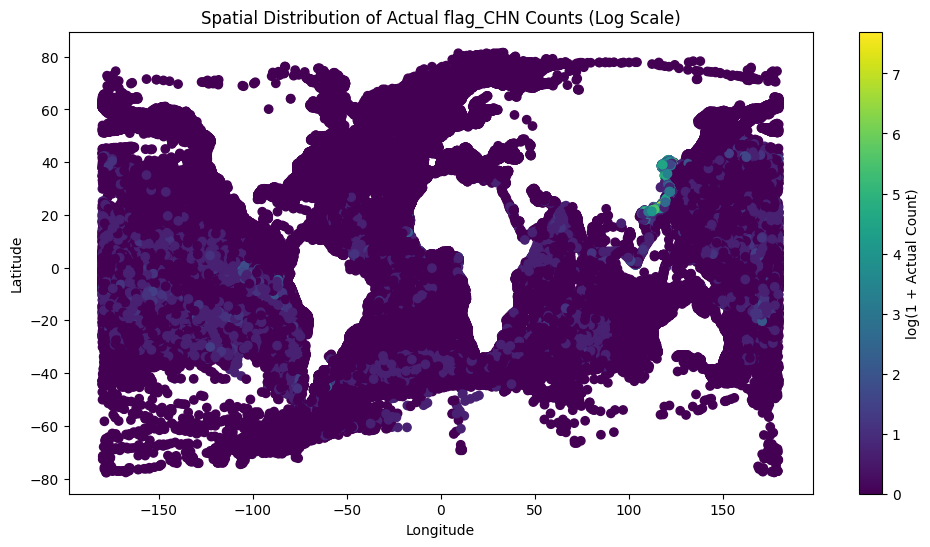

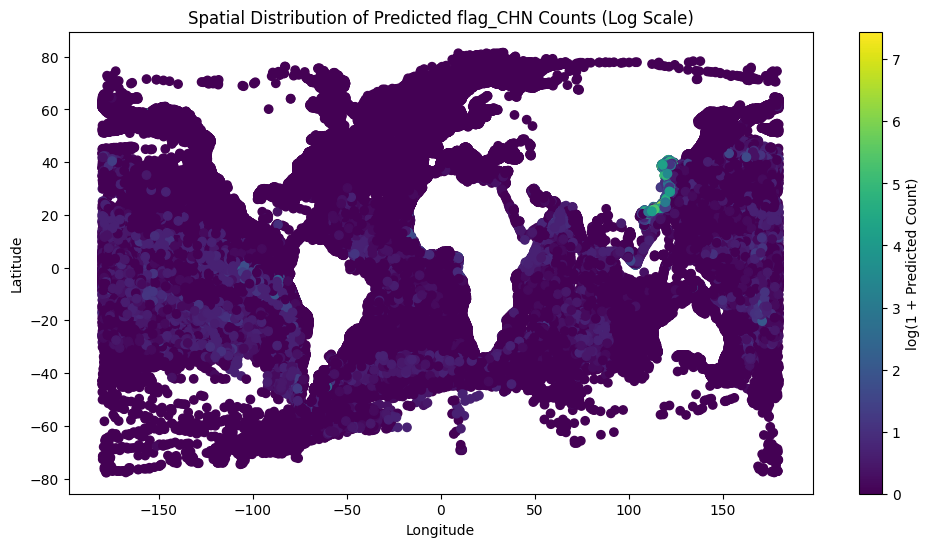

In [24]:
# This is a spatial map of first the actual counts of Chinese Flagged Vessels (log scale) vs Our predicted flagged vessels (log scale)

flag = 'flag_CHN'

plt.figure(figsize=(12, 6))
plt.scatter(X_test['cell_ll_lon'], X_test['cell_ll_lat'], c=np.log1p(y_test[flag]), cmap='viridis')
plt.colorbar(label='log(1 + Actual Count)')
plt.title(f"Spatial Distribution of Actual {flag} Counts (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(X_test['cell_ll_lon'], X_test['cell_ll_lat'], c=np.log1p(rf_preds[:, list(y_test.columns).index(flag)]), cmap='viridis', label='Predicted')
plt.colorbar(label='log(1 + Predicted Count)')
plt.title(f"Spatial Distribution of Predicted {flag} Counts (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## It's difficult to visually determine this much data, but just a brief glance looks like our model is doing pretty well for Chinese flagged vessels at the very least. By eye these maps looks identical.